In [1]:
import json
import os
import random
from PIL import Image
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
import numpy as np

import panoptic_parts as pp
from panoptic_parts.utils.visualization import set_use_legacy_cpp_parts_colormap
set_use_legacy_cpp_parts_colormap(False)


In [2]:
import glob
import os
label_path = "/data/cityscapes_panoptic_parts/gtFinePanopticParts/val"
label_files = glob.glob(os.path.join(label_path, "*/*.tif"))

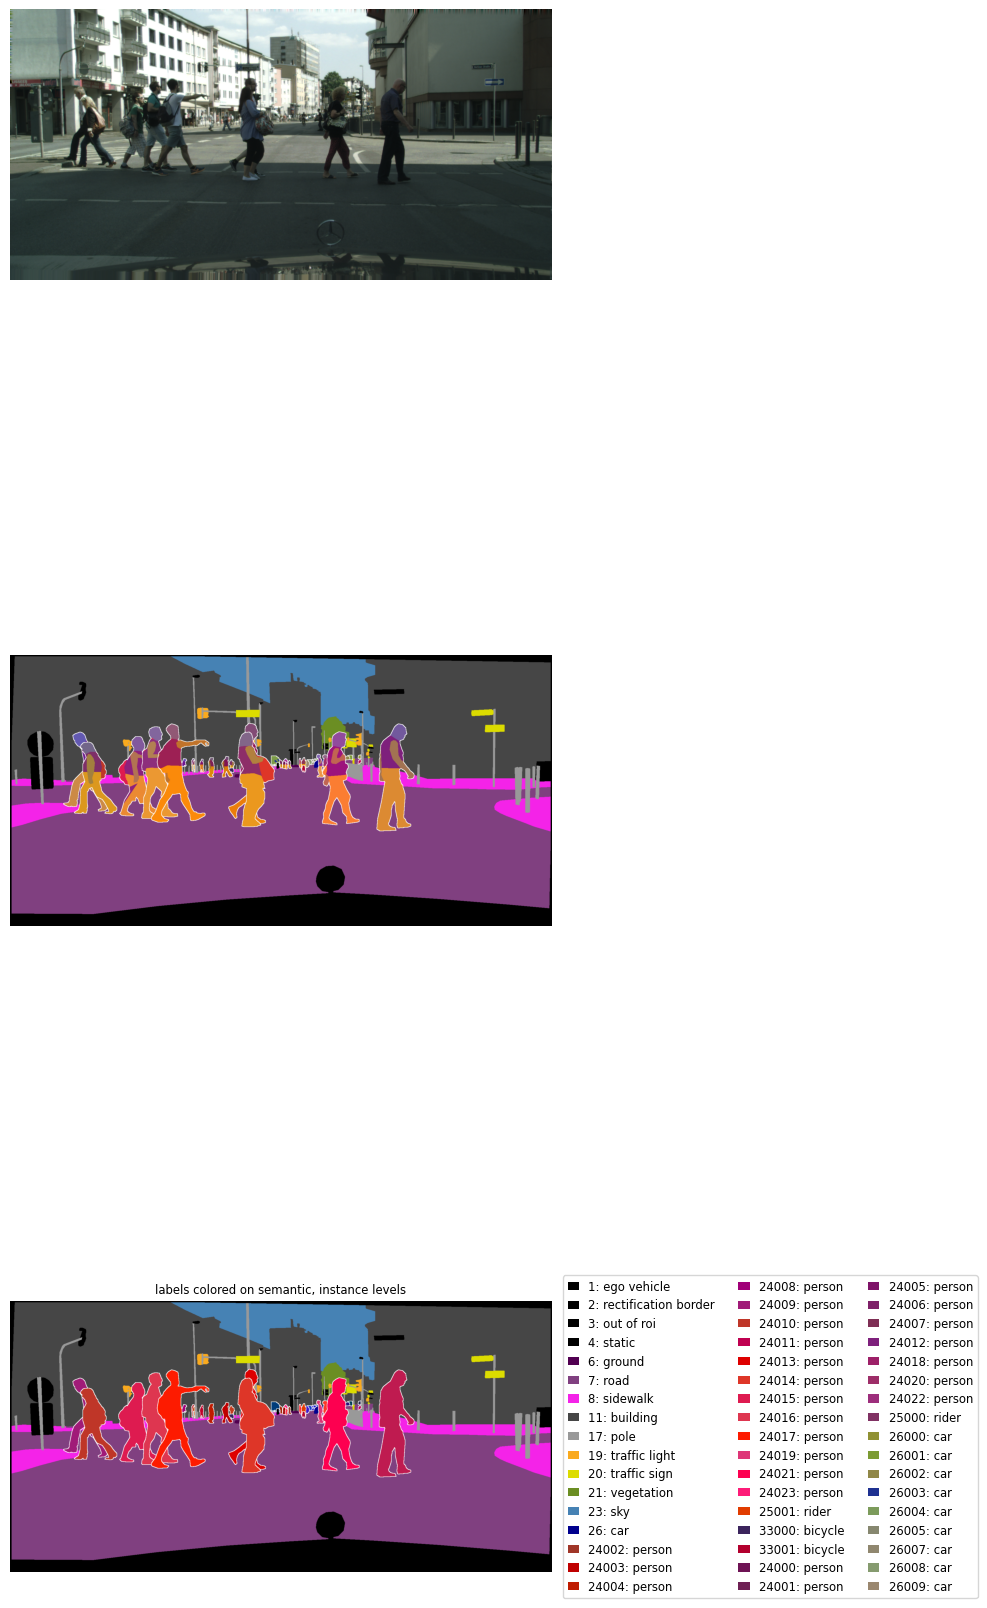

In [33]:
from panoptic_parts import encode_ids, decode_uids
from panoptic_parts.visualization.visualize_label_with_legend import experimental_colorize_label

spec = pp.specs.dataset_spec.DatasetSpec("cpp_spec.yaml")

split = "val"
img_dir = f"/data/cityscapes/leftImg8bit/{split}"
label_dir = f"/data/cityscapes_panoptic_parts/gtFinePanopticParts/{split}"

full_label_files = glob.glob(os.path.join(label_dir, "*/*.tif"))
label_file_full = random.choice(label_files)

label_split = label_file_full.split('/')[-1].replace('.tif','').split('_')
city = label_split[0]
img_id = label_split[1] + '_' + label_split[2]
img_file_full = os.path.join(img_dir, city, f"{city}_{img_id}_leftImg8bit.png")
img = Image.open(img_file_full)

# for label in labels:
uids = np.array(Image.open(label_file_full), dtype=np.int32)
uids = encode_ids(*decode_uids(uids, experimental_dataset_spec=spec, experimental_correct_range=True))

uids_sem_inst_parts_colored, uids_sem_inst_colored, uid2color_dct = experimental_colorize_label(
    uids, sid2color=spec.sid2scene_color, emphasize_instance_boundaries=True,  return_uid2color=True, return_sem_inst=True,
    experimental_deltas=(60, 60, 60), experimental_alpha=0.5)

# plot
_, axes = plt.subplots(3, 1, figsize=(10, 20))
ax0, ax1, ax2 = axes

# generate legend, h is a hidden rectangle just to create a legend entry
handles = []
handles_text = []
uids_unique = np.unique(uids)
for uid in uids_unique:
    h = plt.Rectangle((0, 0), 1, 1, fc=list(map(lambda x: x/255, uid2color_dct[uid])))
    handles.append(h)
    _, _, _, sid_pid = decode_uids(uid, return_sids_pids=True)
    scene_class_part_class = spec.scene_class_part_class_from_sid_pid(sid_pid)
    handles_text.append(f'{uid}: {scene_class_part_class}')

ax0.imshow(img)
ax1.imshow(uids_sem_inst_parts_colored)
# ax1.set_title('labels colored on semantic, instance, and part levels', fontsize='small')
# ax1.legend(handles, handles_text, ncol=3, fontsize='small', handlelength=1.0,
#           loc='center left', bbox_to_anchor=(1.01, 0.5))


handles = []
handles_text = []
all_sid_iids = set()
for uid in uids_unique:
    sid, _, _, sid_iid = decode_uids(uid, return_sids_iids=True)
    if str(sid_iid) in all_sid_iids:
        continue
    all_sid_iids.add(str(sid_iid))
    h = plt.Rectangle((0, 0), 1, 1, fc=list(map(lambda x: x/255, uid2color_dct[uid])))
    handles.append(h)
    scene_class = spec.scene_class_from_sid(sid)
    handles_text.append(f'{sid_iid}: {scene_class}')

ax2.imshow(uids_sem_inst_colored)
ax2.set_title('labels colored on semantic, instance levels', fontsize='small')
ax2.legend(handles, handles_text, ncol=3, fontsize='small', handlelength=1.0,
          loc='center left', bbox_to_anchor=(1.01, 0.5))
#plt.show()
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
plt.tight_layout()


11 11 -1 -1


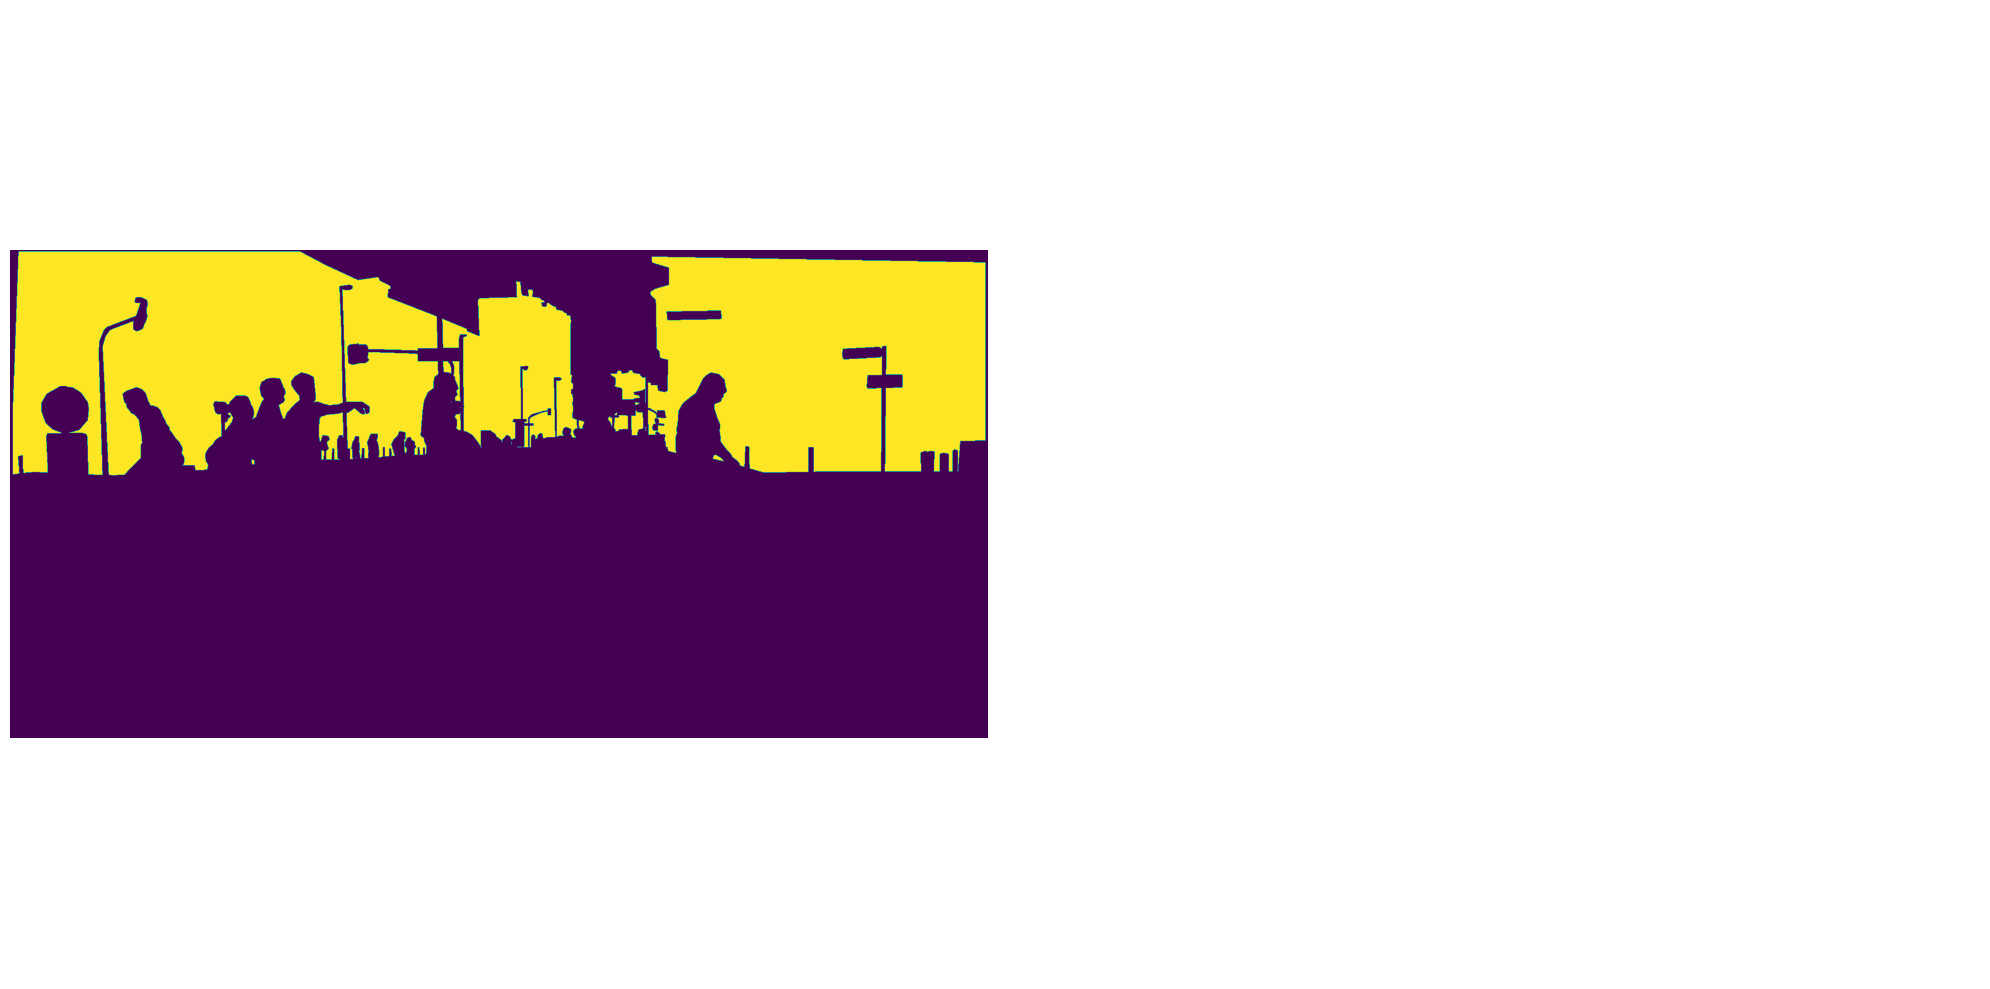

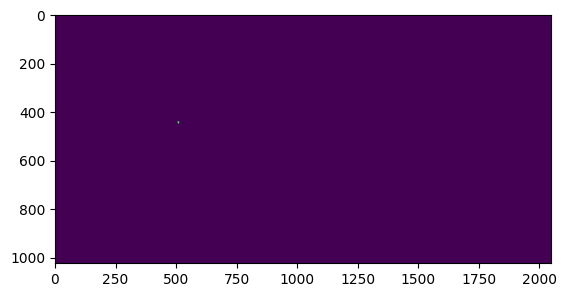

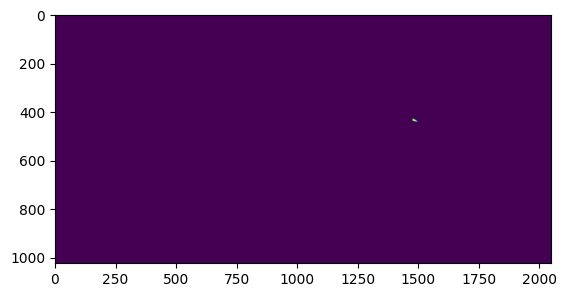

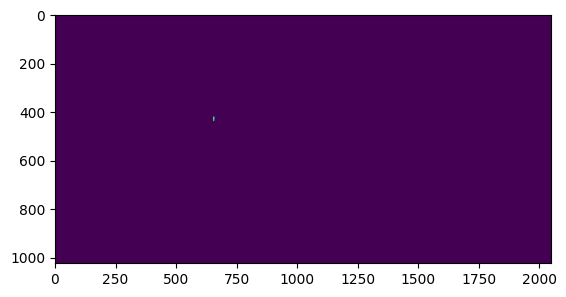

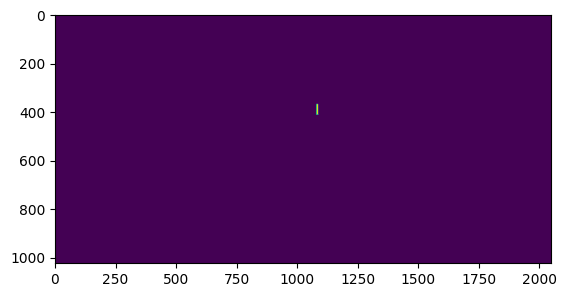

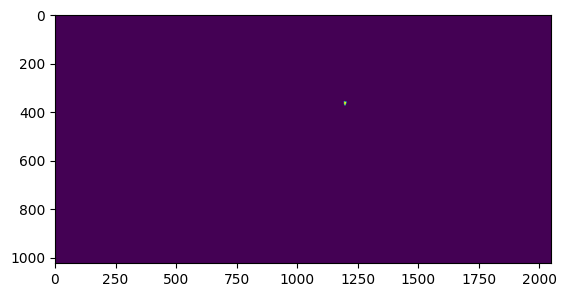

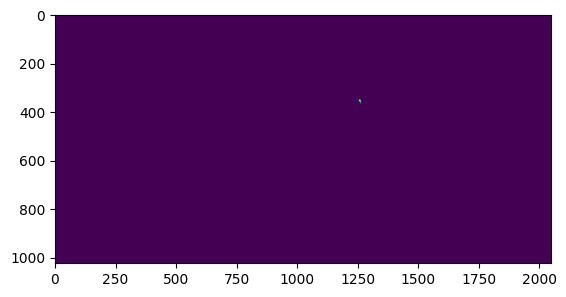

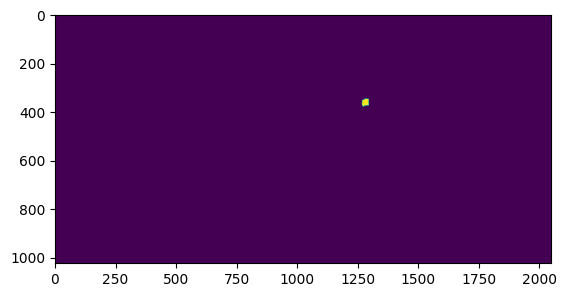

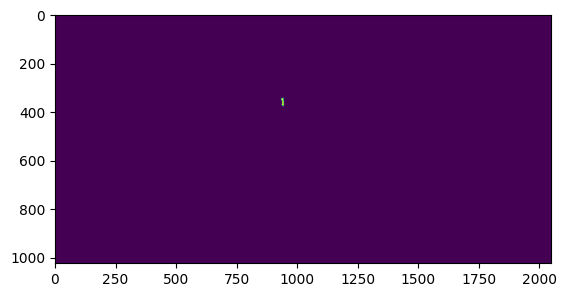

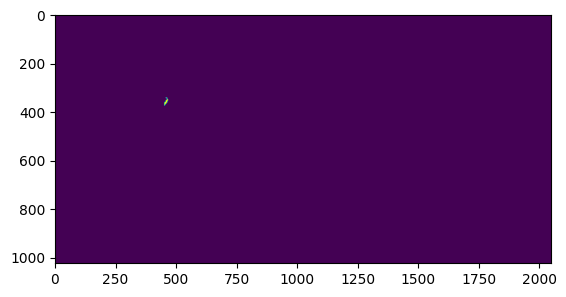

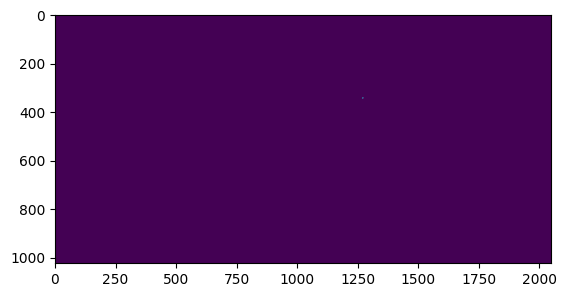

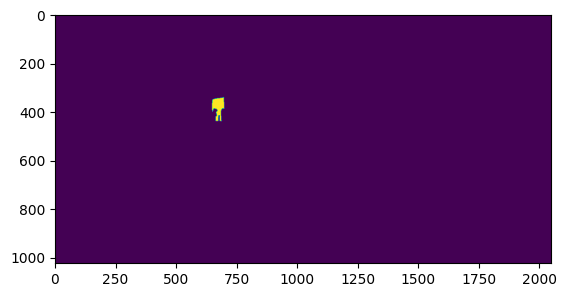

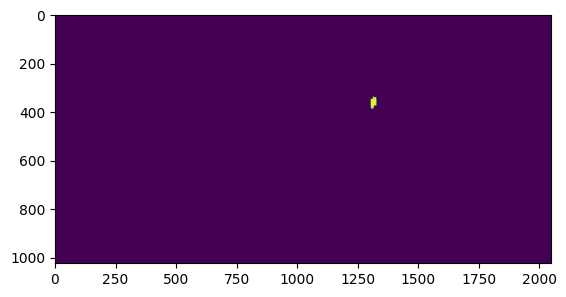

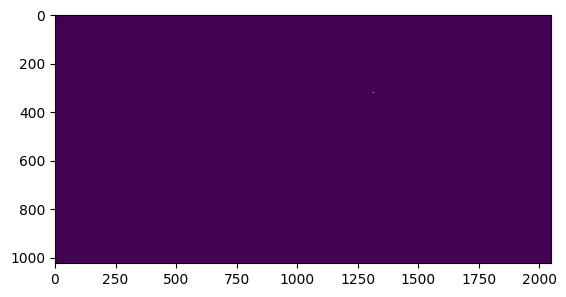

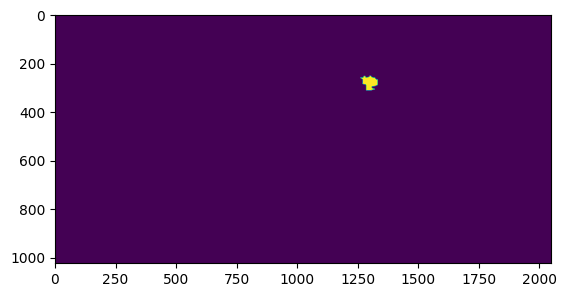

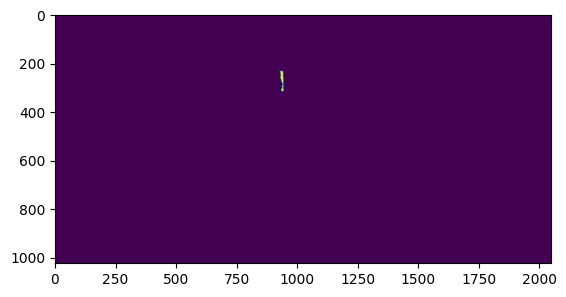

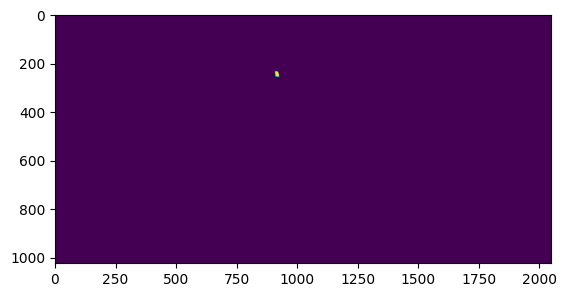

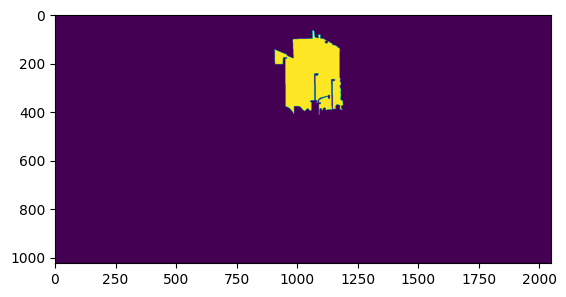

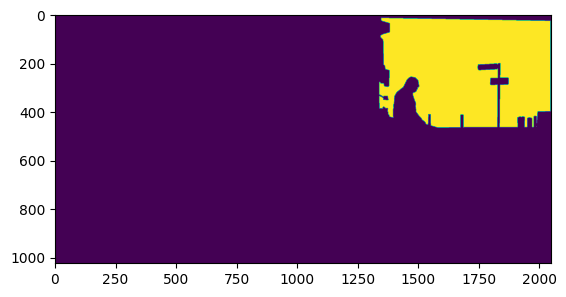

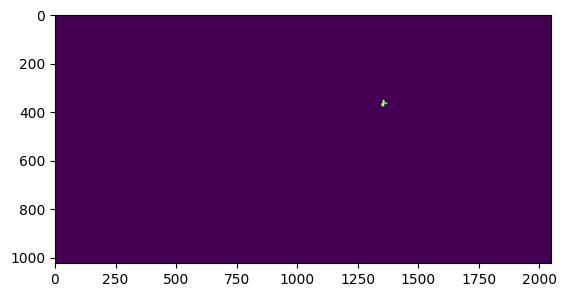

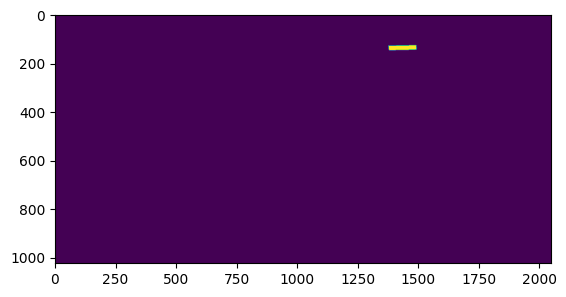

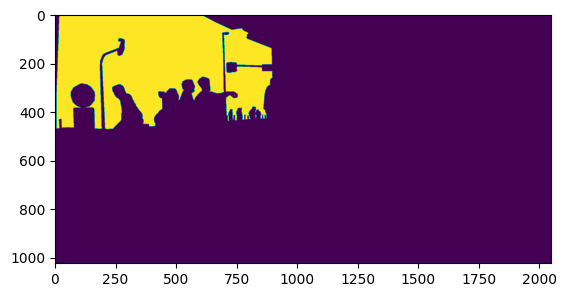

In [38]:
import cv2

uid = 11 # uids_unique[7]
color = uid2color_dct[uid]
sid, iid, pid = decode_uids(uid)
print(uid, sid, iid, pid)

unique_colors = np.unique(uids_sem_inst_colored.reshape(-1, 3), axis=0)
# find a mask where the color is present
mask_0 = np.all(uids_sem_inst_colored == color, axis=-1)
# mask_1 = np.all(uids_sem_inst_colored == unique_colors[1], axis=-1)
# plot
_, axes = plt.subplots(1, 2, figsize=(20, 10))
ax0, ax1 = axes

ax0.imshow(mask_0.astype(np.uint8))
# ax1.imshow(mask_1.astype(np.uint8))

ax0.axis('off')
ax1.axis('off')
plt.tight_layout()
plt.show()

# find contours
contours, hierarchy = cv2.findContours(mask_0.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# contour to coco rle mask

for c in contours:
    c = c.flatten().tolist()
    if len(c) > 4:
        rle = maskUtils.frPyObjects([c], mask_0.shape[0], mask_0.shape[1])
        mask = maskUtils.decode(rle)
        plt.imshow(mask)
        plt.show()

# for c in contours:
# c = contours[1]
# c = c.flatten().tolist()
# if len(c) > 4:
#     rle = maskUtils.frPyObjects([c], mask_0.shape[0], mask_0.shape[1])
#     mask = ~maskUtils.decode(rle)
#     plt.imshow(mask)
#     plt.show()
    

# plot
# _, ax0 = plt.subplots(1, 1, figsize=(10, 10))

# ax0.imshow(mask)
# ax0.axis('off')